In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
from utils.ml_utils import *
from pyod.models.ecod import ECOD

In [6]:
file_path = "Data/metrics_collector.tsv"

column_names = [
    'account_id', 'name', 'point', 'call_count', 'total_call_time', 
    'total_exclusive_time', 'min_call_time', 'max_call_time', 
    'sum_of_squares', 'instances', 'language', 'app_name', 
    'app_id', 'scope', 'host', 'display_host', 'pid', 
    'agent_version', 'labels'
]

data = pd.read_csv(file_path, sep='\t', header=None)
data.columns = column_names
metrics_table = make_table(data)
metrics_table

/var/folders/n9/qf3jg31d5rz3v4ydwp7__zfm0000gn/T/ipykernel_45789/471163818.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', header=None)
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["point"] = pd.to_datetime(filtered_data["point"])
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,time,time_numeric,web_response,throughput,apdex,error
0,2024-04-15 23:32:00,28553732.0,0.015006,3898.0,0.999679,0.000128
1,2024-04-15 23:33:00,28553733.0,0.015006,3917.5,0.999745,0.000128
2,2024-04-15 23:34:00,28553734.0,0.015006,3993.0,0.999687,0.000000
3,2024-04-15 23:35:00,28553735.0,0.015006,3991.5,0.999812,0.000000
4,2024-04-15 23:36:00,28553736.0,0.015006,3915.5,0.999489,0.000000
...,...,...,...,...,...,...
43267,2024-05-16 00:54:00,28597014.0,0.015006,2560.0,0.998828,0.000000
43268,2024-05-16 00:55:00,28597015.0,0.015006,2491.0,0.998495,0.000000
43269,2024-05-16 00:56:00,28597016.0,0.015006,2429.0,0.997736,0.000206
43270,2024-05-16 00:57:00,28597017.0,0.015006,2373.5,0.997999,0.000211


In [3]:
metrics_table.dtypes

time            datetime64[ns]
time_numeric           float64
web_response           float64
throughput             float64
apdex                  float64
error                  float64
dtype: object

In [4]:
metrics_table = make_table(data)
metrics_table

/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = filtered_data['point']
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['web_response'] = filtered_data['total_call_time'].sum() / filtered_data['call_count'].sum()


In [5]:
metrics_table

,time,web_response,throughput,apdex,error
0,2024-04-15 23:32:00,0.015006,3898.0,0.999679,0.000128
1,2024-04-15 23:33:00,0.015006,3917.5,0.999745,0.000128
2,2024-04-15 23:34:00,0.015006,3993.0,0.999687,0.000000
3,2024-04-15 23:35:00,0.015006,3991.5,0.999812,0.000000
4,2024-04-15 23:36:00,0.015006,3915.5,0.999489,0.000000
...,...,...,...,...,...
43267,2024-05-16 00:54:00,0.015006,2560.0,0.998828,0.000000
43268,2024-05-16 00:55:00,0.015006,2491.0,0.998495,0.000000
43269,2024-05-16 00:56:00,0.015006,2429.0,0.997736,0.000206
43270,2024-05-16 00:57:00,0.015006,2373.5,0.997999,0.000211


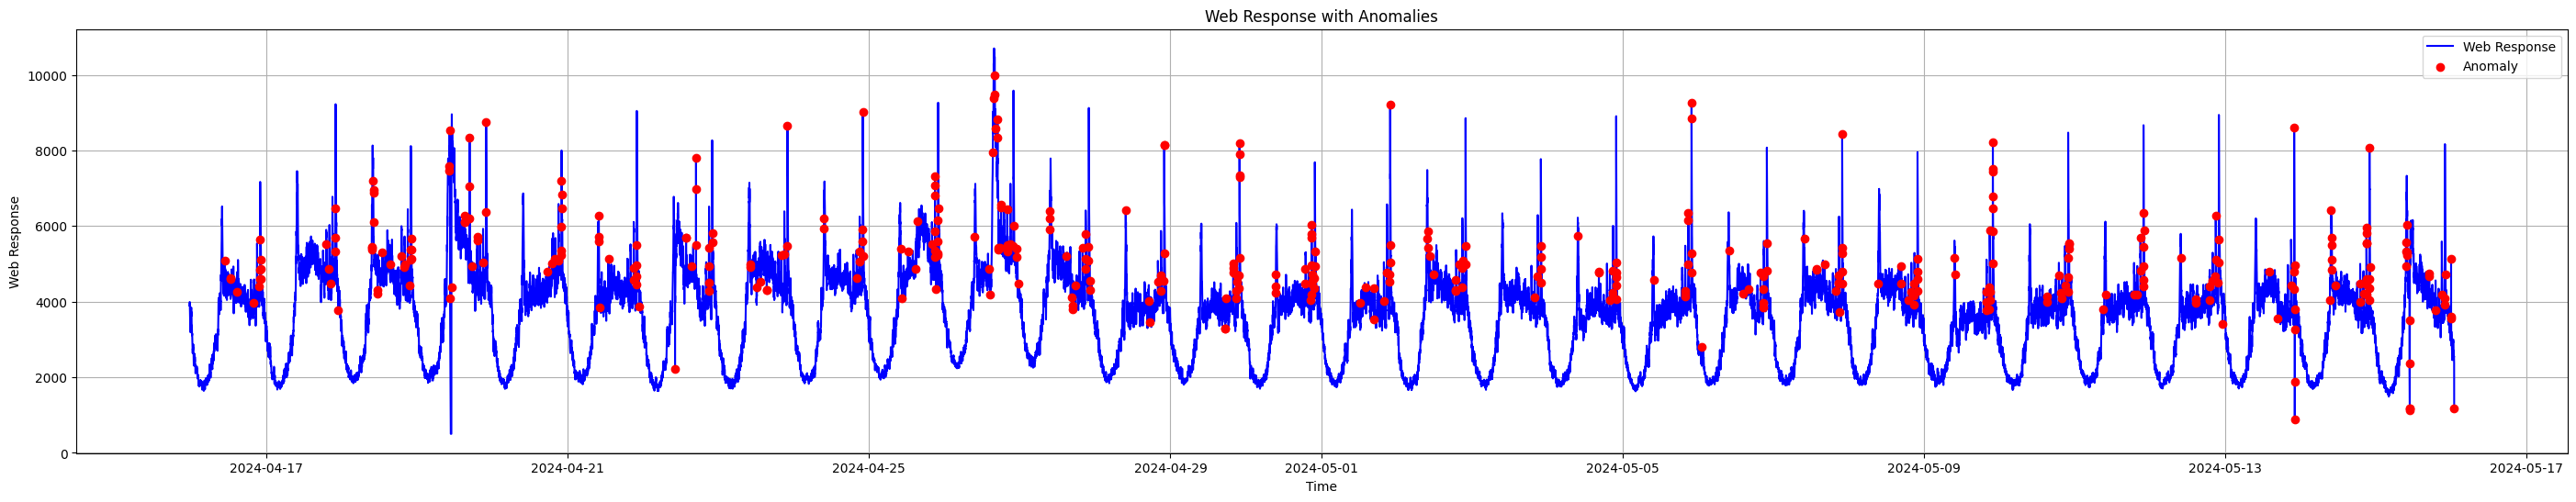

In [13]:
metrics_table['time_numeric'] = pd.to_datetime(metrics_table['time']).astype(int) / 10**9  # Преобразование в секунды

# Извлечение данных столбцов 'time_numeric' и 'web_response'
data = metrics_table[['time_numeric', 'apdex', 'throughput']].values

# Обучение модели IForest
clf = LOF(
    n_neighbors=5,
    contamination=0.0095,
    n_jobs=-1
)

clf.fit(data)

# Прогнозирование аномалий
labels = clf.labels_  # Метки аномалий (0: нормальный, 1: аномалия)
scores = clf.decision_scores_  # Оценки аномалий

# Добавление меток аномалий в DataFrame
metrics_table['anomaly'] = labels

# Преобразование временных меток обратно в datetime для графика
metrics_table['time'] = pd.to_datetime(metrics_table['time'])

# Построение линейного графика с пометкой аномалий
plt.figure(figsize=(35, 6))
plt.plot(metrics_table['time'], metrics_table['throughput'], color='blue', label='Web Response')
plt.scatter(metrics_table[metrics_table['anomaly'] == 1]['time'], metrics_table[metrics_table['anomaly'] == 1]['throughput'], color='red', label='Anomaly', zorder=5)
plt.title('Web Response with Anomalies')
plt.xlabel('Time')
plt.ylabel('Web Response')
plt.legend()
plt.grid(True)
plt.show()

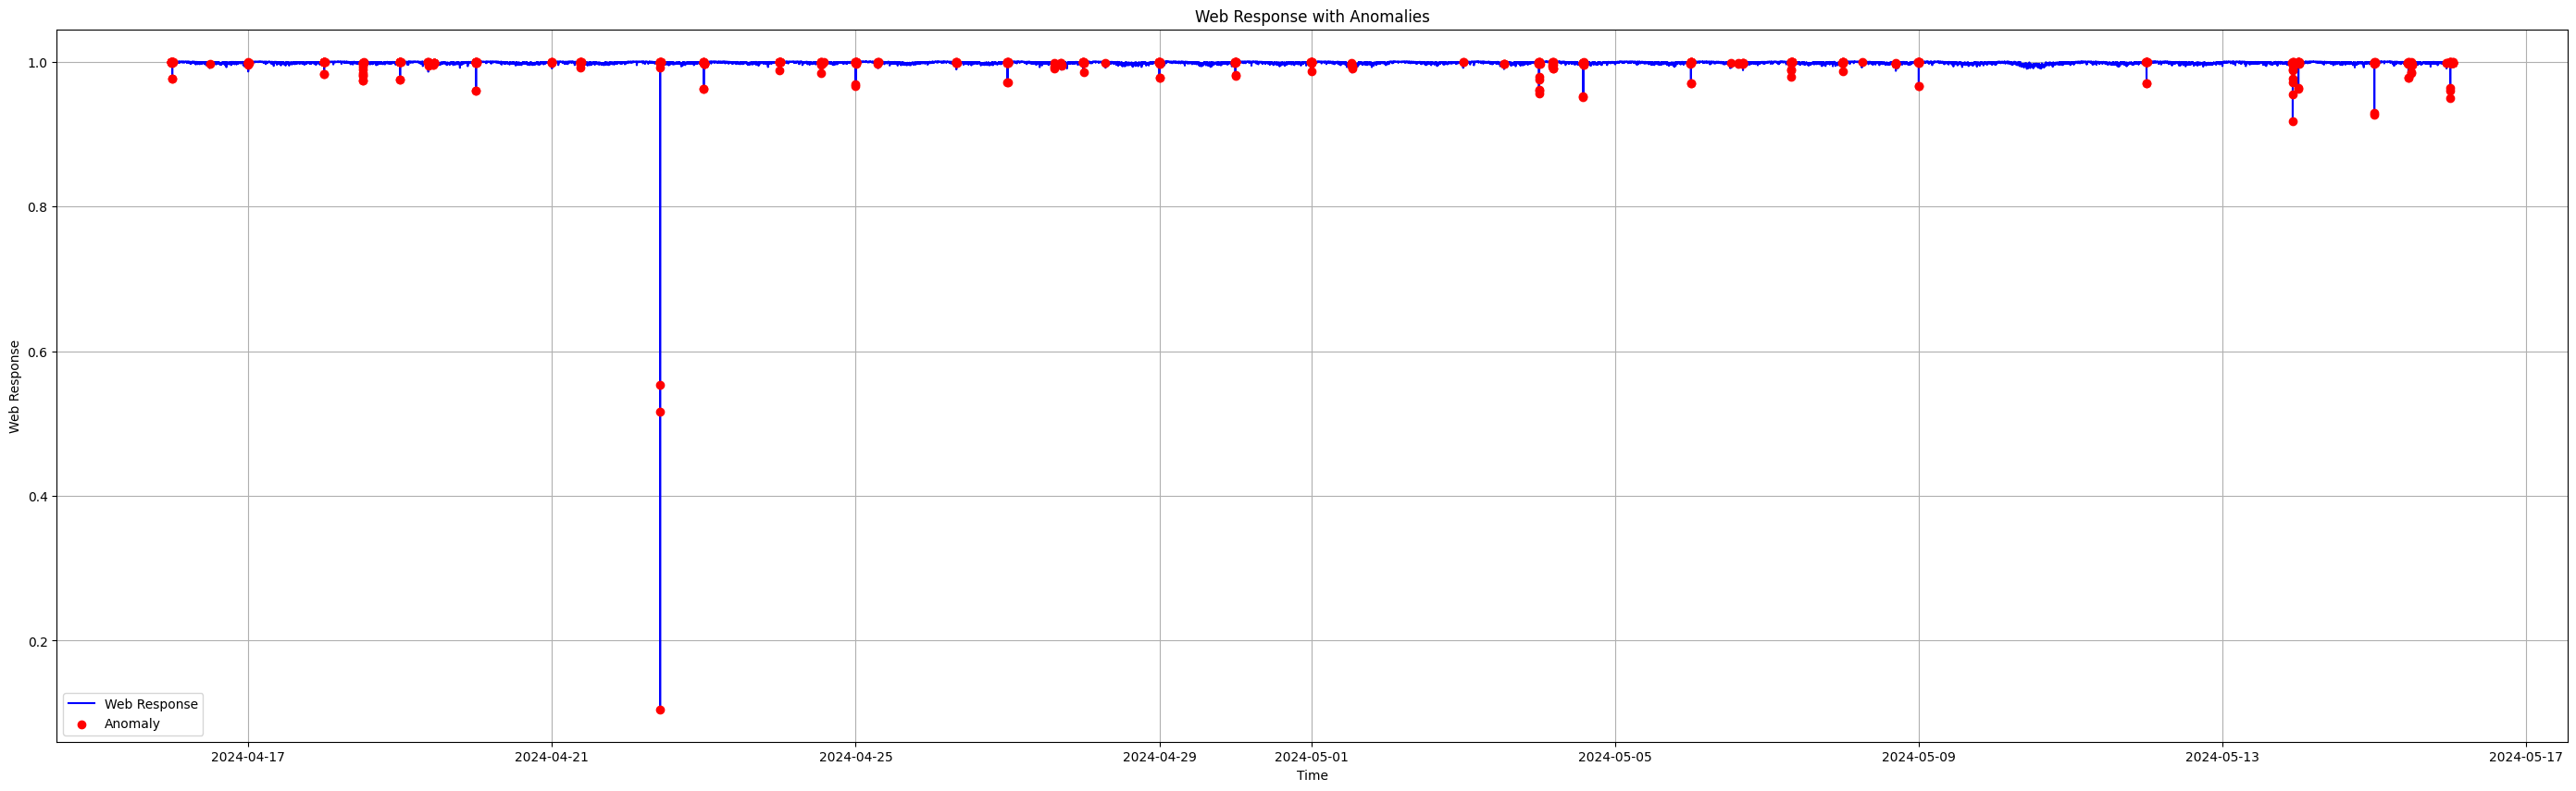

{'variance_diff': -95.36764784211968, 'fraction_anomaly': 0.011000184877056757}

In [12]:
clf = LOF(
    n_neighbors=10,
    contamination=0.011,
    n_jobs=-1
)

metrics_table['time_numeric'] = pd.to_datetime(metrics_table['time']).astype(int) / 10**9  # Преобразование в секунды

# Извлечение данных столбцов 'time_numeric' и 'web_response'
data = metrics_table[['time_numeric', 'apdex']].values
clf.fit(data)

# Прогнозирование аномалий
labels = clf.labels_  # Метки аномалий (0: нормальный, 1: аномалия)
scores = clf.decision_scores_  # Оценки аномалий

# Добавление меток аномалий в DataFrame
metrics_table['anomaly'] = labels

# Преобразование временных меток обратно в datetime для графика
metrics_table['time'] = pd.to_datetime(metrics_table['time'])

# Построение линейного графика с пометкой аномалий
plt.figure(figsize=(35, 10))
plt.plot(metrics_table['time'], metrics_table['apdex'], color='blue', label='Web Response')
plt.scatter(metrics_table[metrics_table['anomaly'] == 1]['time'], metrics_table[metrics_table['anomaly'] == 1]['apdex'], color='red', label='Anomaly', zorder=5)
plt.title('Web Response with Anomalies')
plt.xlabel('Time')
plt.ylabel('Web Response')
plt.legend()
plt.grid(True)
plt.show()

data = pd.DataFrame(data, columns=['time_numeric', 'apdex'])
metrics_name = "apdex"
metrics(data, labels, metrics_name)

In [11]:
data

array([[1.71322392e+09, 9.99679323e-01],
       [1.71322398e+09, 9.99744735e-01],
       [1.71322404e+09, 9.99686952e-01],
       ...,
       [1.71582096e+09, 9.97735694e-01],
       [1.71582102e+09, 9.97998736e-01],
       [1.71582108e+09, 9.99145299e-01]])

In [8]:
clf = ECOD()
clf.fit(metrics_table[["time_numeric", "apdex"]])

# Прогнозирование аномалий
labels = clf.labels_  # Метки аномалий (0: нормальный, 1: аномалия)
scores = clf.decision_scores_

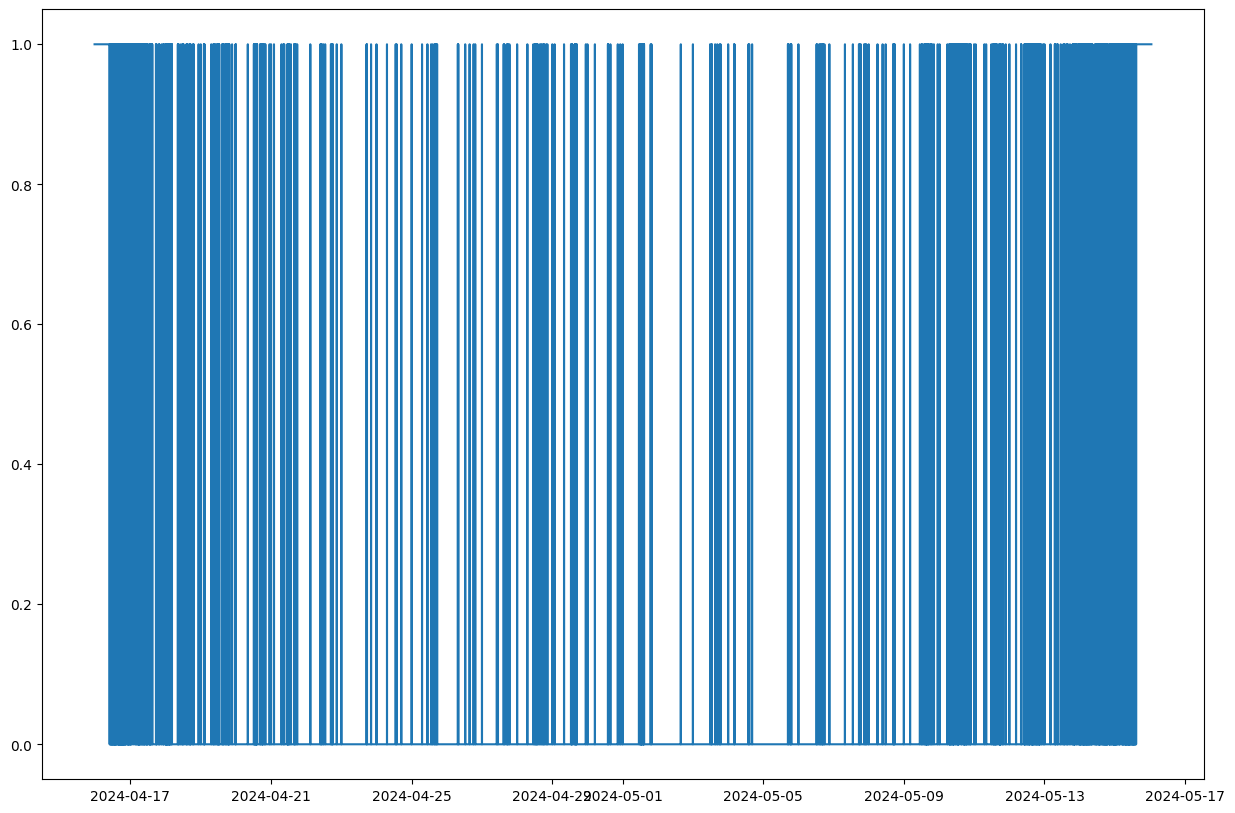

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(metrics_table["time"], labels)